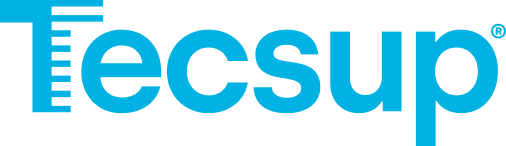

# DEPARTAMENTO DE TECNOLOGÍA DIGITAL Y GESTIÓN
## Carrera de Big Data y Ciencia de Datos
# LABORATORIO 11

## Integrantes:
- Joshua Jian Cora Salazar
- Kevin Estiben Olortegui Perez

In [3]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

In [11]:
URL = "https://drive.google.com/file/d/1Gn2_7CGAX0D0M3Ka3JKSjlEdrWbKCxH0/view?usp=sharing"
URL = 'https://drive.google.com/uc?id=' + URL.split('/')[-2]
df = pl.read_csv(URL)
df.head()

TV,Radio,Newspaper,Sales
f64,f64,f64,f64
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9


In [20]:

# 2. Análisis de datos faltantes
print("Datos faltantes por columna:")
print(df.null_count())

# 3. Tratamiento de outliers (univariado)
def remove_outliers(df, columns):
    for col in columns:
        if df[col].dtype in [pl.Float64, pl.Int64]:  # Solo para numéricas
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_val = q3 - q1
            lower_bound = q1 - 1.5 * iqr_val
            upper_bound = q3 + 1.5 * iqr_val
            df = df.filter(
                (pl.col(col) >= lower_bound) & 
                (pl.col(col) <= upper_bound)
            )
    return df

numeric_cols = ['TV', 'Radio', 'Newspaper', 'Sales']
df_clean = remove_outliers(df, numeric_cols)

# 4. Escalamiento de datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_clean.with_columns(
    [pl.Series(name=f"{col}_scaled",
              values=scaler.fit_transform(df_clean[col].to_numpy().reshape(-1, 1)).flatten())
     for col in numeric_cols]
)

# Resultado final
print("\nDatos preprocesados:")
print(df_scaled.head())


Datos faltantes por columna:
shape: (1, 4)
┌─────┬───────┬───────────┬───────┐
│ TV  ┆ Radio ┆ Newspaper ┆ Sales │
│ --- ┆ ---   ┆ ---       ┆ ---   │
│ u32 ┆ u32   ┆ u32       ┆ u32   │
╞═════╪═══════╪═══════════╪═══════╡
│ 0   ┆ 0     ┆ 0         ┆ 0     │
└─────┴───────┴───────────┴───────┘

Datos preprocesados:
shape: (5, 8)
┌───────┬───────┬───────────┬───────┬───────────┬──────────────┬──────────────────┬──────────────┐
│ TV    ┆ Radio ┆ Newspaper ┆ Sales ┆ TV_scaled ┆ Radio_scaled ┆ Newspaper_scaled ┆ Sales_scaled │
│ ---   ┆ ---   ┆ ---       ┆ ---   ┆ ---       ┆ ---          ┆ ---              ┆ ---          │
│ f64   ┆ f64   ┆ f64       ┆ f64   ┆ f64       ┆ f64          ┆ f64              ┆ f64          │
╞═══════╪═══════╪═══════════╪═══════╪═══════════╪══════════════╪══════════════════╪══════════════╡
│ 230.1 ┆ 37.8  ┆ 69.2      ┆ 22.1  ┆ 0.978697  ┆ 0.989521     ┆ 1.932998         ┆ 1.566517     │
│ 44.5  ┆ 39.3  ┆ 45.1      ┆ 10.4  ┆ -1.199012 ┆ 1.090705     ┆ 0.751313  

b. Cree un algoritmo genético para seleccionar las mejores variables para un modelo de regresión
lineal incluyendo diversos valores para los parámetros: tamaño de la población, probabilidad
de cruce, probabilidad de mutación y número de generaciones.

In [21]:

# 1. Preparar los datos (continuación de la parte a)
X = df_scaled.select([pl.col(f"{col}_scaled") for col in numeric_cols if col != 'Sales']).to_numpy()
y = df_scaled['Sales_scaled'].to_numpy()
feature_names = [col for col in numeric_cols if col != 'Sales']

# 2. Configuración del algoritmo genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(feature_names))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [22]:
# 3. Función de evaluación (R²)
def evaluate(individual):
    selected = [feature_names[i] for i, val in enumerate(individual) if val == 1]
    if not selected:  # Si no selecciona ninguna característica
        return 0.0,
    
    # Usar Polars para seleccionar las columnas
    X_selected = df_scaled.select([f"{col}_scaled" for col in selected]).to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [23]:
# 4. Parámetros del algoritmo (puedes ajustarlos)
params = {
    'population_size': 50,
    'crossover_prob': 0.7,
    'mutation_prob': 0.2,
    'generations': 20
}

# 5. Ejecución del algoritmo
pop = toolbox.population(n=params['population_size'])
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(
    pop, toolbox,
    cxpb=params['crossover_prob'],
    mutpb=params['mutation_prob'],
    ngen=params['generations'],
    stats=stats,
    halloffame=hof,
    verbose=True
)

gen	nevals	avg     	min       	max     
0  	50    	0.348359	-0.0452239	0.902888
1  	39    	0.64601 	-0.0452239	0.902888
2  	41    	0.832946	0.568818  	0.902888
3  	40    	0.89021 	0.611569  	0.902888
4  	38    	0.902652	0.898945  	0.902888
5  	30    	0.902888	0.902888  	0.902888
6  	36    	0.90281 	0.898945  	0.902888
7  	41    	0.897062	0.611569  	0.902888
8  	37    	0.902888	0.902888  	0.902888
9  	42    	0.874425	0.336953  	0.902888
10 	48    	0.868271	0.328486  	0.902888
11 	33    	0.90281 	0.898945  	0.902888
12 	38    	0.902888	0.902888  	0.902888
13 	43    	0.902888	0.902888  	0.902888
14 	36    	0.90281 	0.898945  	0.902888
15 	39    	0.902888	0.902888  	0.902888
16 	44    	0.8914  	0.328486  	0.902888
17 	36    	0.885743	0.336953  	0.902888
18 	37    	0.897062	0.611569  	0.902888
19 	44    	0.896128	0.568818  	0.902888
20 	36    	0.897062	0.611569  	0.902888


In [24]:
# 6. Resultados
best_individual = hof[0]
selected_features = [feature_names[i] for i, val in enumerate(best_individual) if val == 1]
print(f"\nMejores variables seleccionadas: {selected_features}")
print(f"R² máximo alcanzado: {best_individual.fitness.values[0]:.4f}")


Mejores variables seleccionadas: ['TV', 'Radio']
R² máximo alcanzado: 0.9029


c. Realice un gráfico de la evolución del coeficiente de determinación (R2), seleccione las mejores variables, cree un modelo de regresión lineal con base a estas tomando un 80% de datos para el entrenamiento y mida su desempeño con el R2.

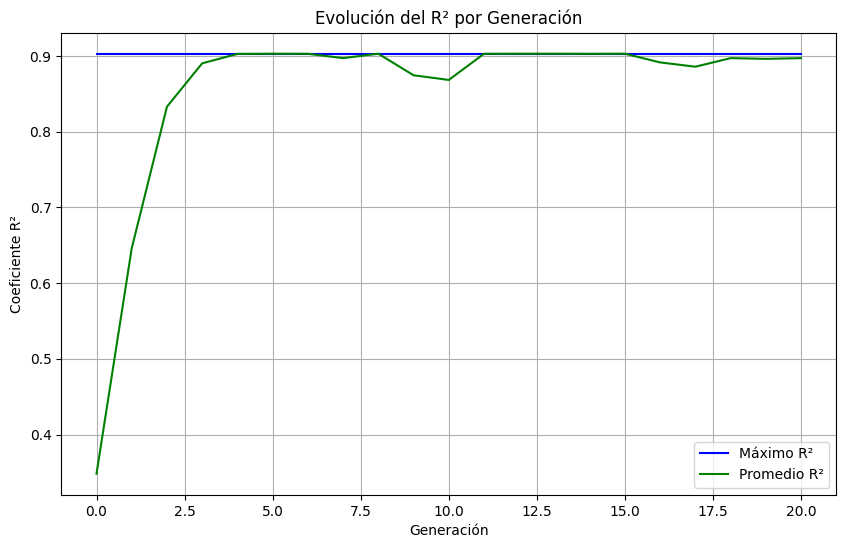

LinearRegression()

In [25]:
# 1. Gráfico de evolución del coeficiente R²
plt.figure(figsize=(10, 6))
gen_numbers = log.select('gen')
max_fitness = log.select('max')
avg_fitness = log.select('avg')

plt.plot(gen_numbers, max_fitness, 'b-', label="Máximo R²")
plt.plot(gen_numbers, avg_fitness, 'g-', label="Promedio R²")
plt.xlabel('Generación')
plt.ylabel('Coeficiente R²')
plt.title('Evolución del R² por Generación')
plt.legend()
plt.grid(True)
plt.show()

# 2. Modelo final con las mejores variables
X_final = df_scaled.select([f"{col}_scaled" for col in selected_features]).to_numpy()
y_final = df_scaled['Sales_scaled'].to_numpy()

# División 80-20 (como especifica el laboratorio)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

# Entrenamiento del modelo final
final_model = LinearRegression()
final_model.fit(X_train, y_train)

In [26]:
# 3. Evaluación del modelo
y_pred = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)

# Resultados
print("\n" + "="*50)
print("Resultados Finales:")
print(f"Variables seleccionadas: {selected_features}")
print(f"R² en conjunto de prueba: {final_r2:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo:")
for feature, coef in zip(selected_features, final_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercepto: {final_model.intercept_:.4f}")
print("="*50)


Resultados Finales:
Variables seleccionadas: ['TV', 'Radio']
R² en conjunto de prueba: 0.9029

Coeficientes del modelo:
TV: 0.7444
Radio: 0.5294
Intercepto: 0.0007


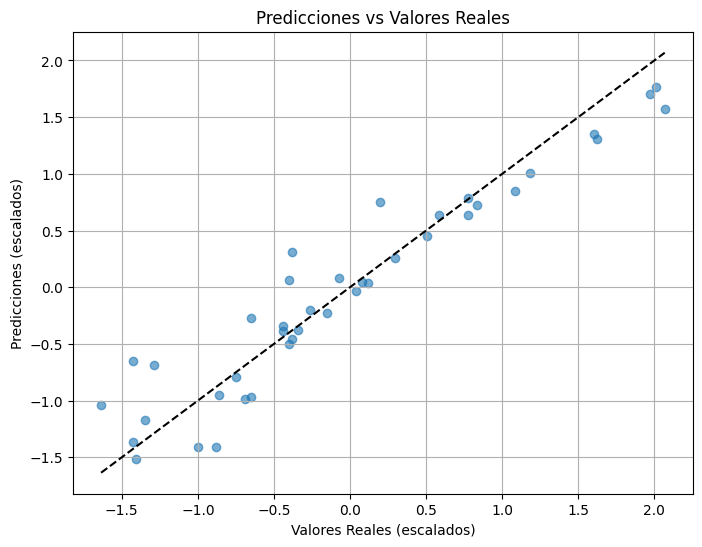

In [27]:
# 4. (Opcional) Gráfico de predicciones vs reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Valores Reales (escalados)')
plt.ylabel('Predicciones (escalados)')
plt.title('Predicciones vs Valores Reales')
plt.grid(True)
plt.show()